In [1]:
#Imports
import tensorflow as tf
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from tensorflow.keras.metrics import *
import os
import tensorflow_addons as tfa

In [2]:
#Loading and preprocessing images
def load_image(path, size, angle, isimage):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if isimage:
        image = cv2.equalizeHist(image)
        image = cv2.blur(image,(4,4))
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (width, height))
    image = image/255. 
    return image

def load_data(size):
    images = []
    masks = []
    
    InputPath = "/kaggle/input/kvasirseg/Kvasir-SEG/"
    SourceImg = sorted(os.listdir(InputPath+'images'))
    TargetImg = sorted(os.listdir(InputPath+'masks'))
    
    for i in range(len(SourceImg)):
        img = load_image(InputPath + 'images/' + SourceImg[i], size, 0, 1)
        #img2 = load_image(InputPath + 'images/' + SourceImg[i], size, 90, 1)
        img3 = load_image(InputPath + 'images/' + SourceImg[i], size, 180, 1)
        #img4 = load_image(InputPath + 'images/' + SourceImg[i], size, 270, 1)
        msk = load_image(InputPath + 'masks/' + TargetImg[i], size, 0, 0)
        #msk2 = load_image(InputPath + 'masks/' + TargetImg[i], size, 90, 0)
        msk3 = load_image(InputPath + 'masks/' + TargetImg[i], size, 180, 0)
        #msk4 = load_image(InputPath + 'masks/' + TargetImg[i], size, 270, 0)
        
        masks.append(msk)
        #masks.append(msk2)
        masks.append(msk3)
        #masks.append(msk4)
        images.append(img)
        #images.append(img2)
        images.append(img3)
        #images.append(img4)
    return np.array(images), np.array(masks)

In [3]:
size = 128
X, y = load_data(size)

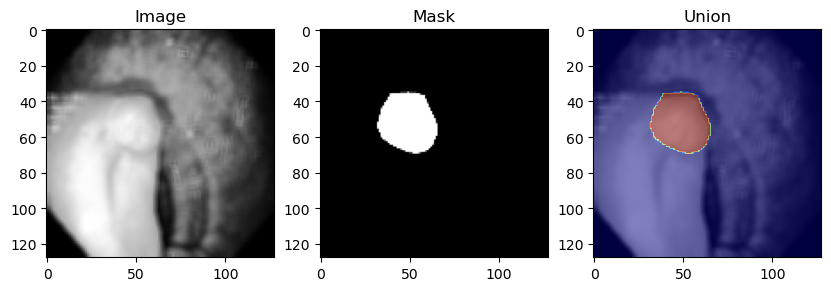

In [4]:
#Cheking one of the images
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(1000)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
plt.show()

In [5]:
#preparing data for modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")


X shape: (2000, 128, 128, 1)  |  y shape: (2000, 128, 128, 1)


In [6]:
#Train-test spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 10)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (1800, 128, 128, 1)
y_train shape: (1800, 128, 128, 1)
X_test shape: (200, 128, 128, 1)
y_test shape: (200, 128, 128, 1)


In [7]:
#defining conv blocks
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

In [8]:
#defining encoder blocks
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

In [9]:
#defining decoder blocks
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

In [10]:
#building the model
def build_model(input_shape):
    input_layer = Input(input_shape)
    
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

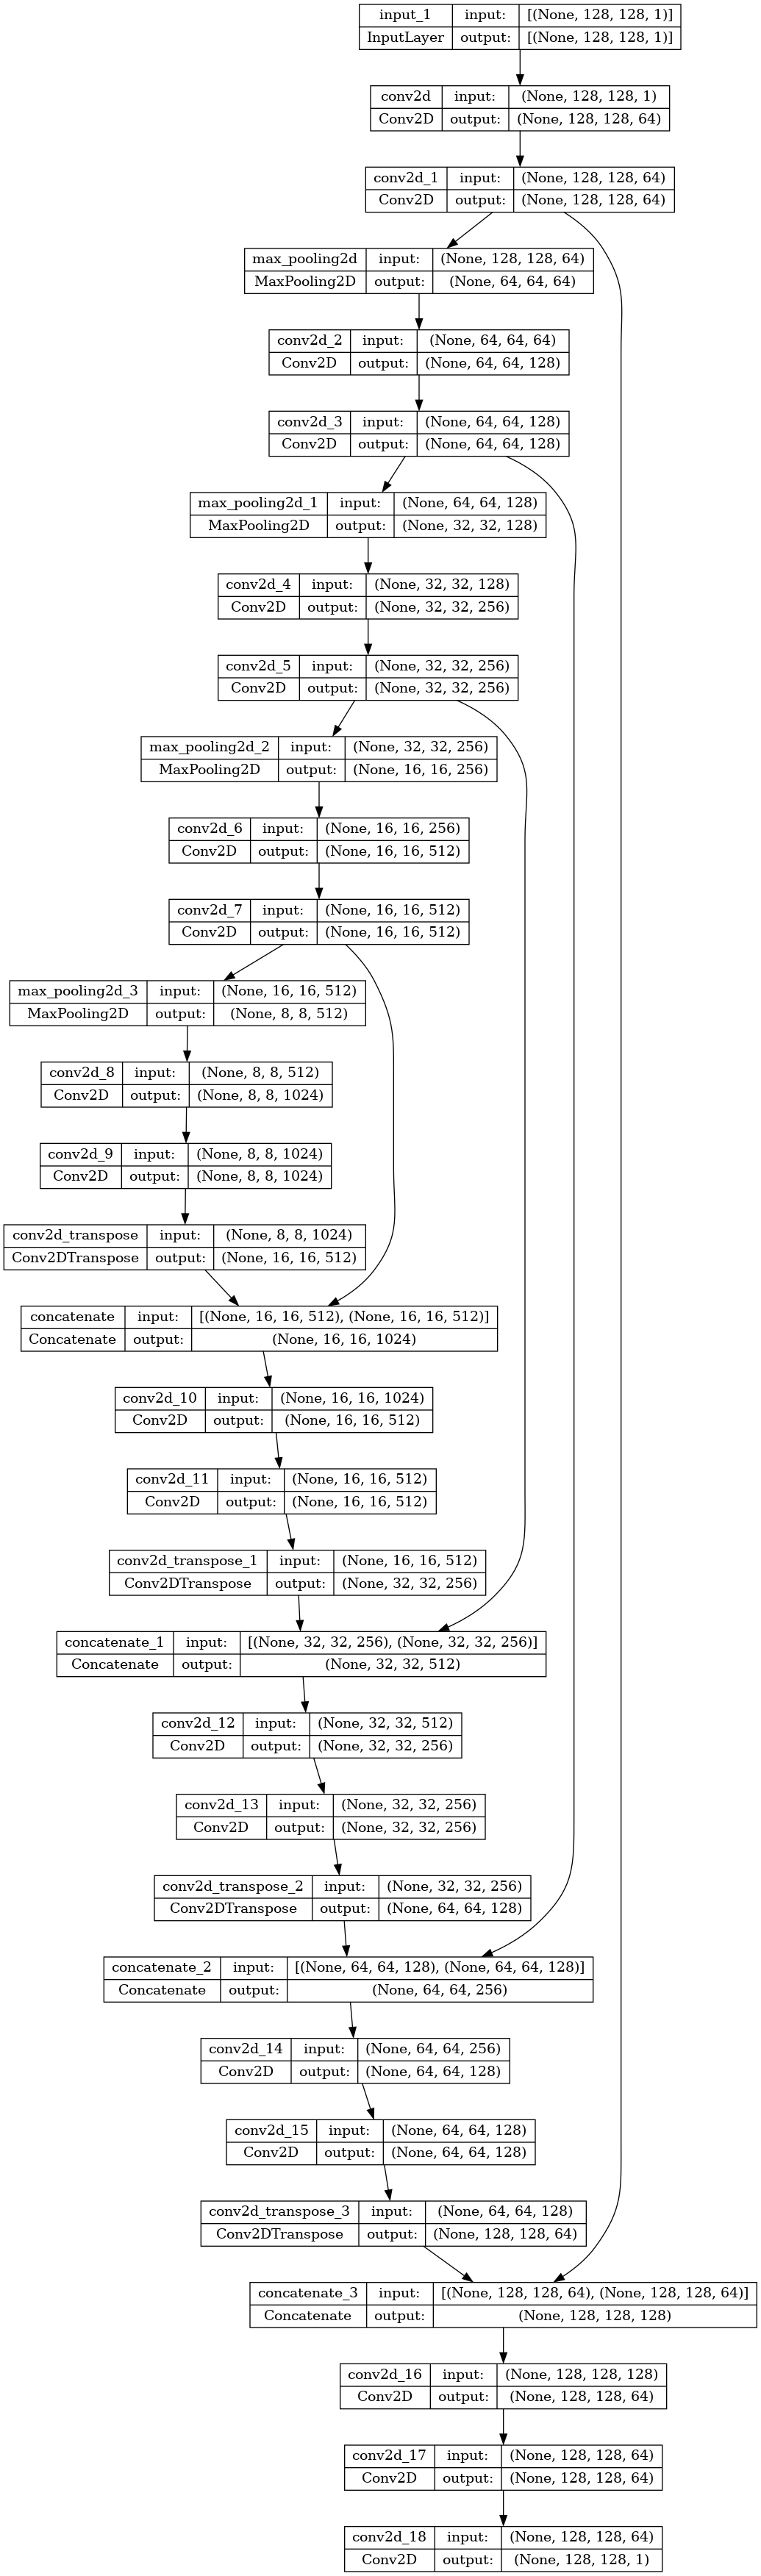

In [11]:
#ploting models structure
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
#printing model's layers
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [13]:
#training the model
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
57/57 [==============================] - 30s 218ms/step - loss: 0.5440 - accuracy: 0.8390 - val_loss: 0.3946 - val_accuracy: 0.8326
Epoch 2/100
57/57 [==============================] - 10s 182ms/step - loss: 0.3836 - accuracy: 0.8409 - val_loss: 0.3878 - val_accuracy: 0.8326
Epoch 3/100
57/57 [==============================] - 10s 183ms/step - loss: 0.3536 - accuracy: 0.8417 - val_loss: 0.3603 - val_accuracy: 0.8361
Epoch 4/100
57/57 [==============================] - 10s 182ms/step - loss: 0.3373 - accuracy: 0.8445 - val_loss: 0.3370 - val_accuracy: 0.8454
Epoch 5/100
57/57 [==============================] - 10s 183ms/step - loss: 0.3286 - accuracy: 0.8501 - val_loss: 0.3738 - val_accuracy: 0.8395
Epoch 6/100
57/57 [==============================] - 10s 183ms/step - loss: 0.3237 - accuracy: 0.8529 - val_loss: 0.3674 - val_accuracy: 0.8430
Epoch 7/100
57/57 [==============================] - 10s 183ms/step - loss: 0.3080 - accuracy: 0.8650 - val_loss: 0.3158 - val_accuracy:

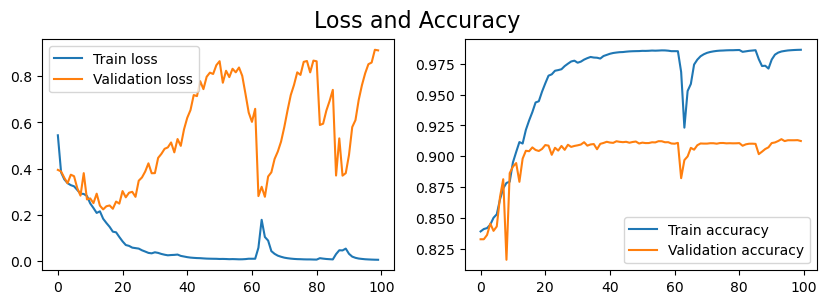

In [14]:
#Ploting loss and acuracy growth based on epochs
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

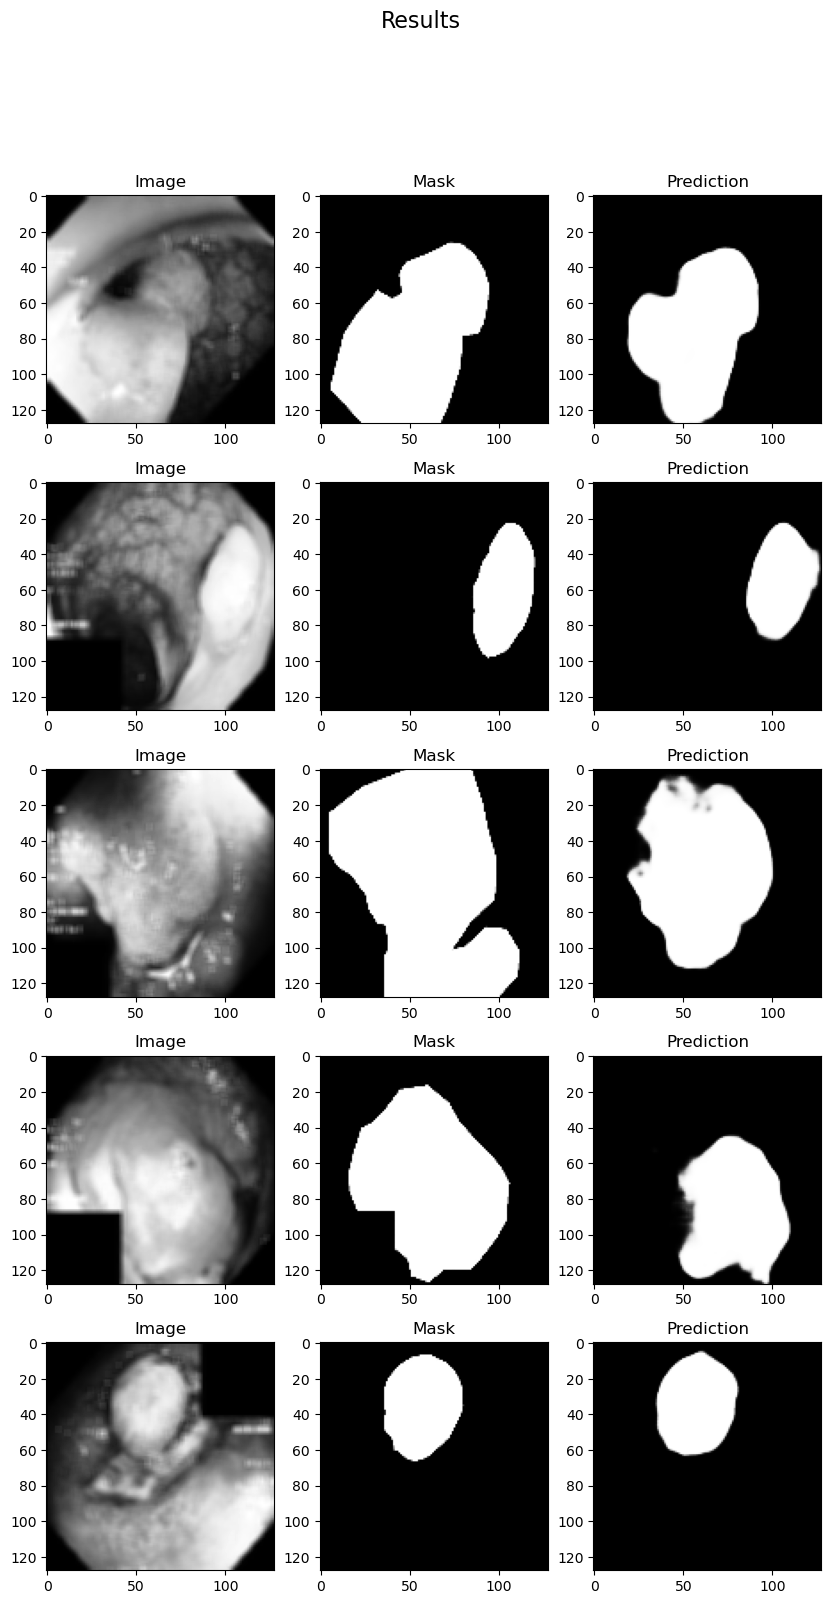

In [15]:
#Visulazing model's results
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

In [16]:
#Measuring our model
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score\Dice Coofficient = %.3f' % f1_score)


Mean IoU = 0.7333802
Precision Score = 0.623
Recall Score = 0.839
F1 Score\Dice Coofficient = 0.715


In [17]:
#Saving the model for further use
model.save('/kaggle/working/Learned-Unet.h5')

7/7 [==============================] - 0s 52ms/step


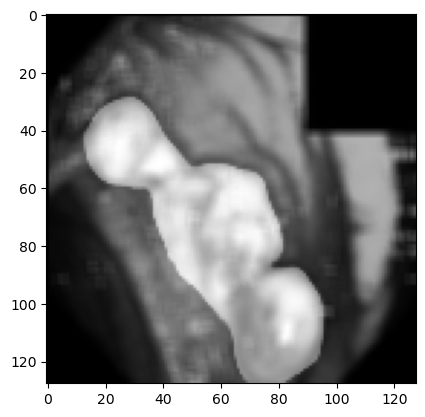

In [18]:
#Merging inputs with their predicted polyp
new_X_train = []
predicts = model.predict(X_train)
for i in range(len(X_train)):
    pred = (predicts[i] + 2 * X_train[i]) / 3
    new_X_train.append(pred)

new_X_train = np.array(new_X_train)
    
new_X_test = []
predicts = model.predict(X_test)
for i in range(len(X_test)):
    pred = (predicts[i] + 2 * X_test[i]) / 3
    new_X_test.append(pred)

new_X_test = np.array(new_X_test)


plt.imshow(new_X_train[0],  cmap='gray')
plt.show()

In [19]:
#Saving new images
os.mkdir(os.path.join('/kaggle/working/', 'converted_train'))
for i in range(len(new_X_train)):
    cv2.imwrite(os.path.join('/kaggle/working/converted_train/', str(i)) + '.jpg', new_X_train[i])
    
os.mkdir(os.path.join('/kaggle/working/', 'converted_test'))
for i in range(len(new_X_test)):
    cv2.imwrite(os.path.join('/kaggle/working/converted_test/', str(i)) + '.jpg', new_X_test[i])

In [20]:
#Saving masks with new names
os.mkdir(os.path.join('/kaggle/working/', 'converted_train_masks'))
for i in range(len(y_train)):
    cv2.imwrite(os.path.join('/kaggle/working/converted_train_masks/', str(i)) + '.jpg', y_train[i])
    
os.mkdir(os.path.join('/kaggle/working/', 'converted_test_masks'))
for i in range(len(y_test)):
    cv2.imwrite(os.path.join('/kaggle/working/converted_test_masks/', str(i)) + '.jpg', y_test[i])

In [21]:
#Spliting new_X_train into train and val
new_X_train, new_X_val, y_train, y_val = train_test_split(new_X_train, y_train, test_size=0.15)
print(new_X_train.shape)
print(new_X_val.shape)

(1530, 128, 128, 1)
(270, 128, 128, 1)


In [22]:
def resblock(X, f):
  
  # make a copy of input
  X_copy = X

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [23]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [24]:
from tensorflow.keras.layers import *

input_shape = (128,128,1)

X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [25]:
model_seg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d_19[0][0]']              
 alization)                     )                                                             

In [26]:
#Losses file in article focal-unet
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [27]:
def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [28]:
# compling model and callbacks functions
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=25
                             )
#saving the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/workingResUNet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [30]:
history = model_seg.fit(new_X_train, y_train, epochs = 250, validation_data = (new_X_val,y_val),
                        callbacks = [checkpointer, earlystopping,reduce_lr])

Epoch 1/250
47/48 [============================>.] - ETA: 0s - loss: 0.0271 - tversky: 0.9919
Epoch 1: val_loss did not improve from 0.02957
48/48 [==============================] - 3s 58ms/step - loss: 0.0270 - tversky: 0.9919 - val_loss: 0.0296 - val_tversky: 0.9908 - lr: 2.0000e-04
Epoch 2/250
47/48 [============================>.] - ETA: 0s - loss: 0.0272 - tversky: 0.9918
Epoch 2: val_loss did not improve from 0.02957
48/48 [==============================] - 3s 59ms/step - loss: 0.0272 - tversky: 0.9918 - val_loss: 0.0296 - val_tversky: 0.9908 - lr: 2.0000e-04
Epoch 3/250
47/48 [============================>.] - ETA: 0s - loss: 0.0269 - tversky: 0.9919
Epoch 3: val_loss did not improve from 0.02957
48/48 [==============================] - 3s 59ms/step - loss: 0.0269 - tversky: 0.9919 - val_loss: 0.0296 - val_tversky: 0.9908 - lr: 2.0000e-04
Epoch 4/250
47/48 [============================>.] - ETA: 0s - loss: 0.0269 - tversky: 0.9919
Epoch 4: val_loss did not improve from 0.02957
4

In [33]:
#Measuring our model
print(f'\033[93m')
y_pred=model_seg.predict(new_X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score\Dice Coofficient = %.3f' % f1_score)


Mean IoU = 0.73544323
Precision Score = 0.631
Recall Score = 0.835
F1 Score\Dice Coofficient = 0.719


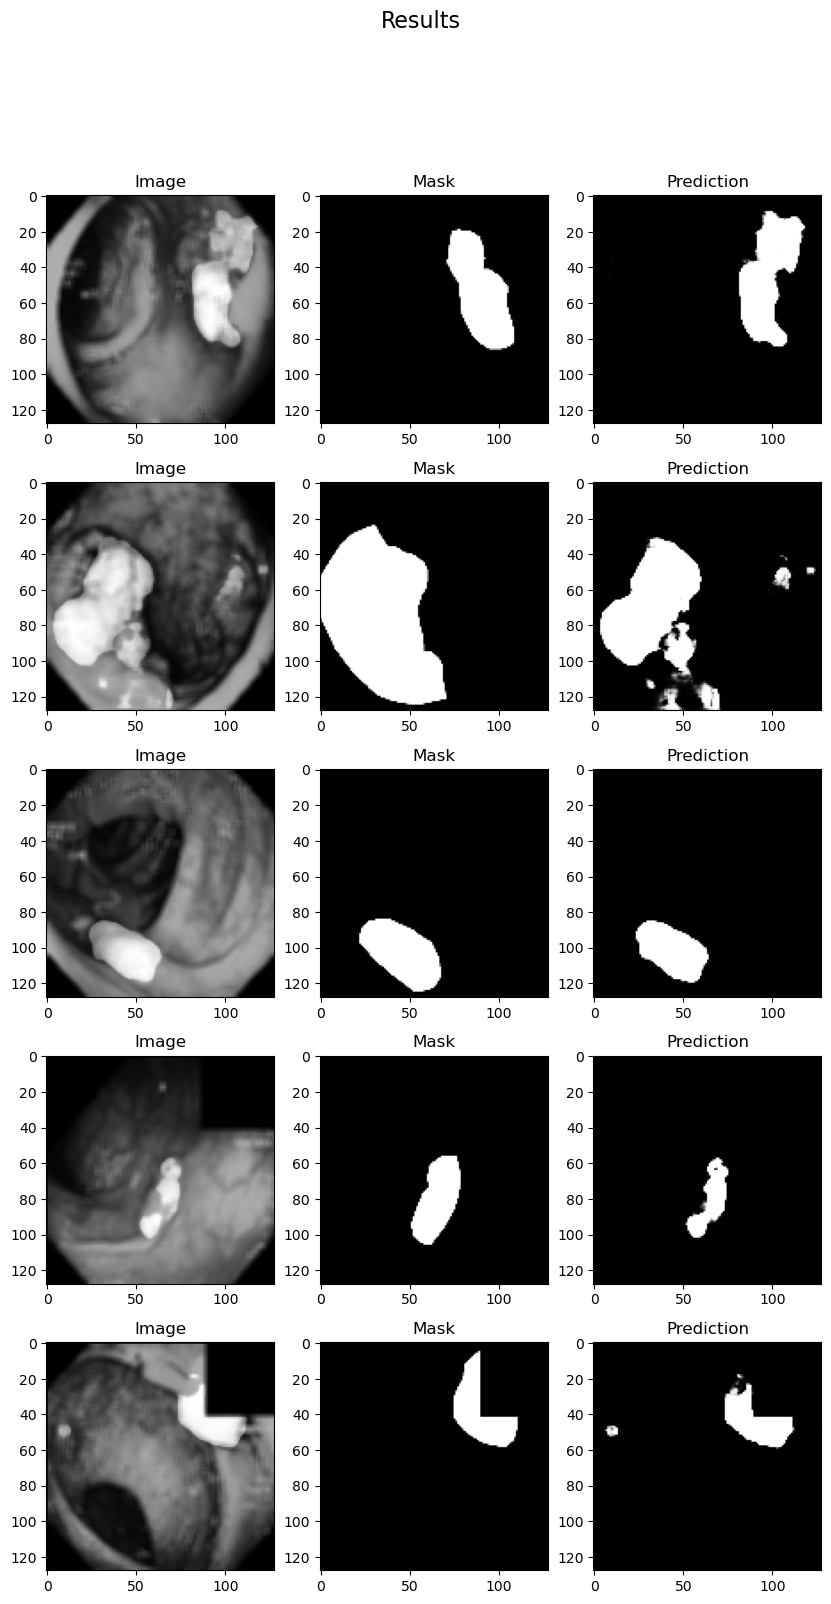

In [34]:
#Visulazing model's results
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, new_X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(new_X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model_seg.predict(np.expand_dims(new_X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

In [35]:
#Saving the model for further use
model_seg.save('/kaggle/working/Learned-Resnet.h5')

In [84]:
model2 = build_model(input_shape=(size, size, 1))
model2.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

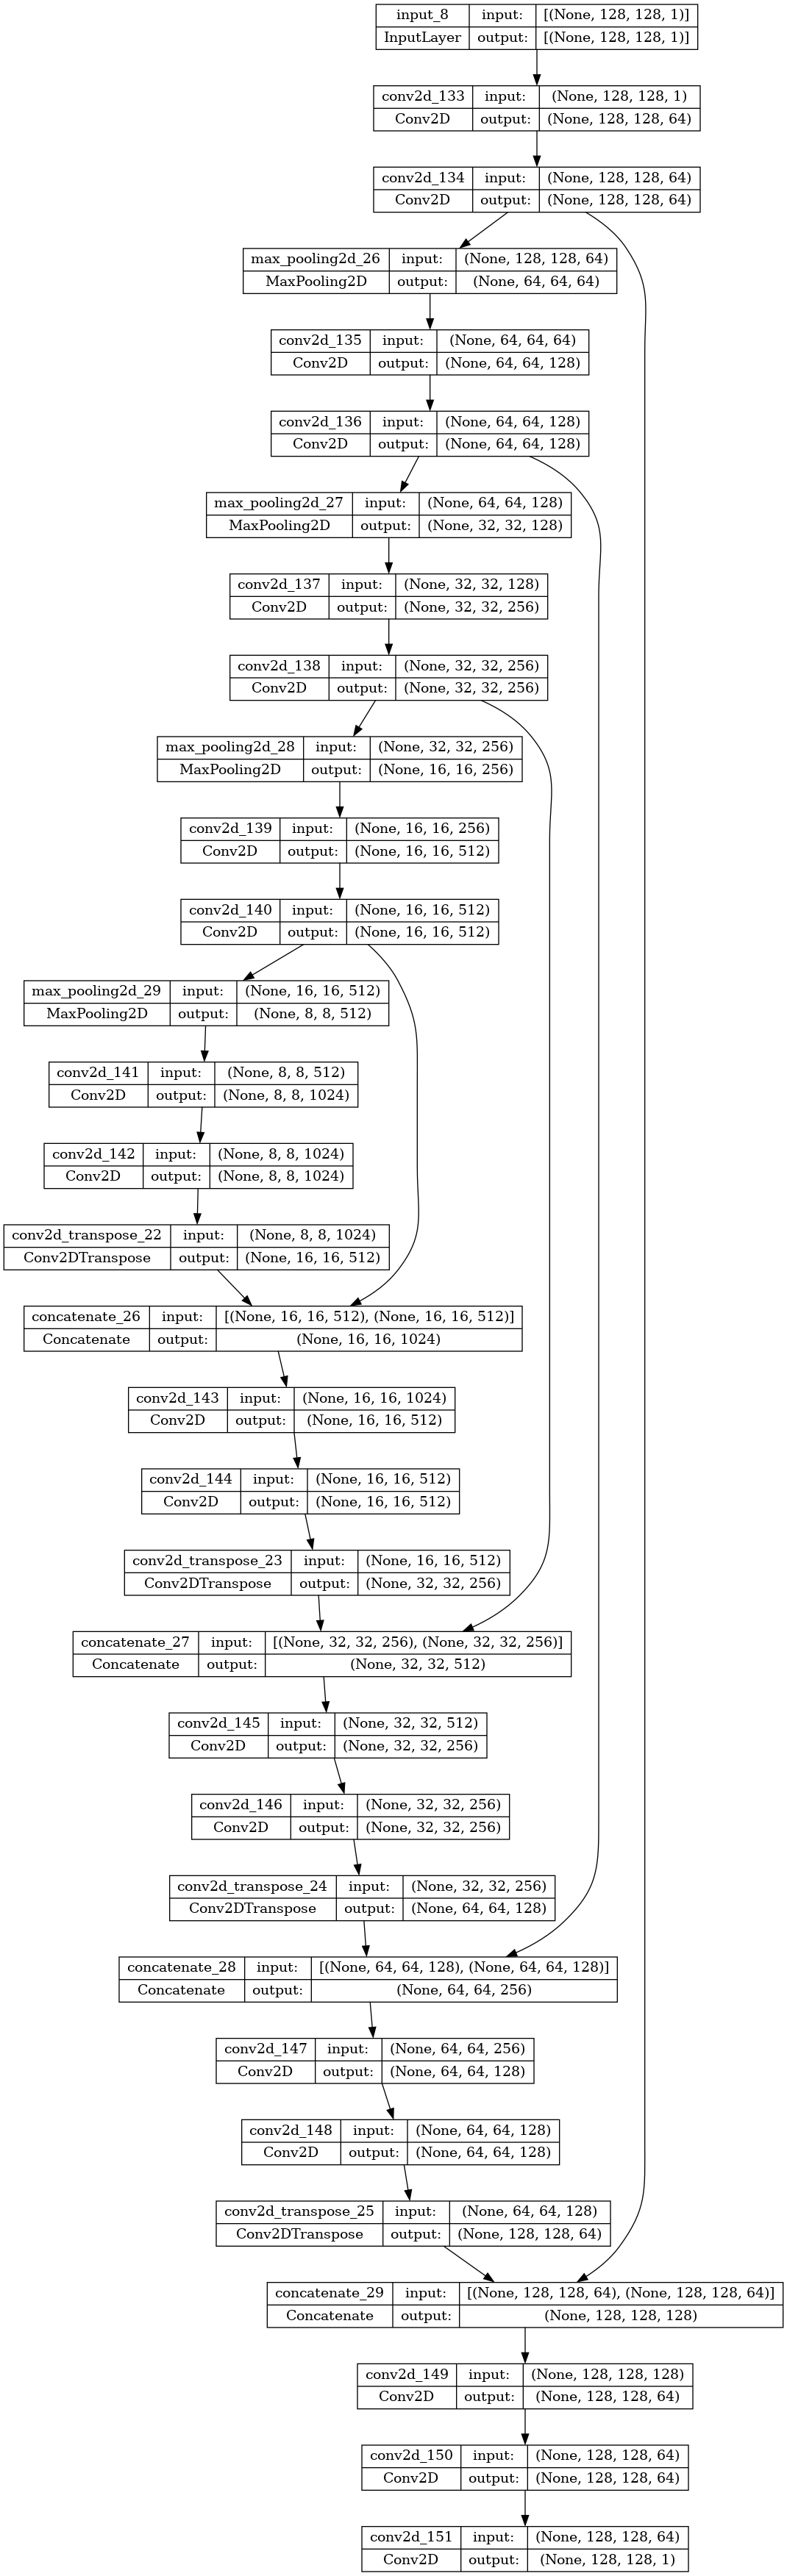

In [85]:
#ploting models structure
tf.keras.utils.plot_model(model2, show_shapes=True)

In [86]:
#printing model's layers
model2.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 128, 128, 64  640         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_134 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_133[0][0]']             
                                )                                                             

In [88]:
#training the model
history = model2.fit(new_X_train, y_train, epochs = 50, validation_data = (new_X_test,y_test))

Epoch 1/50
48/48 [==============================] - 9s 186ms/step - loss: 0.1427 - accuracy: 0.9426 - val_loss: 0.3523 - val_accuracy: 0.9054
Epoch 2/50
48/48 [==============================] - 9s 186ms/step - loss: 0.0975 - accuracy: 0.9543 - val_loss: 0.4096 - val_accuracy: 0.9064
Epoch 3/50
48/48 [==============================] - 9s 186ms/step - loss: 0.0784 - accuracy: 0.9616 - val_loss: 0.4266 - val_accuracy: 0.8991
Epoch 4/50
48/48 [==============================] - 9s 186ms/step - loss: 0.0469 - accuracy: 0.9737 - val_loss: 0.5495 - val_accuracy: 0.9112
Epoch 5/50
48/48 [==============================] - 9s 186ms/step - loss: 0.0153 - accuracy: 0.9841 - val_loss: 0.6845 - val_accuracy: 0.9128
Epoch 6/50
48/48 [==============================] - 9s 186ms/step - loss: 0.0699 - accuracy: 0.9704 - val_loss: 0.4005 - val_accuracy: 0.8083
Epoch 7/50
48/48 [==============================] - 9s 185ms/step - loss: 0.1758 - accuracy: 0.9253 - val_loss: 0.3961 - val_accuracy: 0.8802
Epoch 

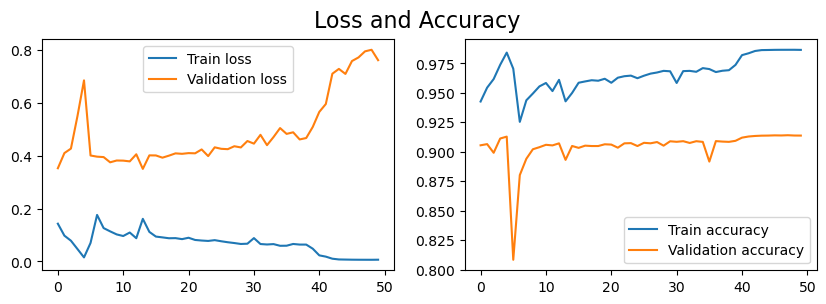

In [89]:
#Ploting loss and acuracy growth based on epochs
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

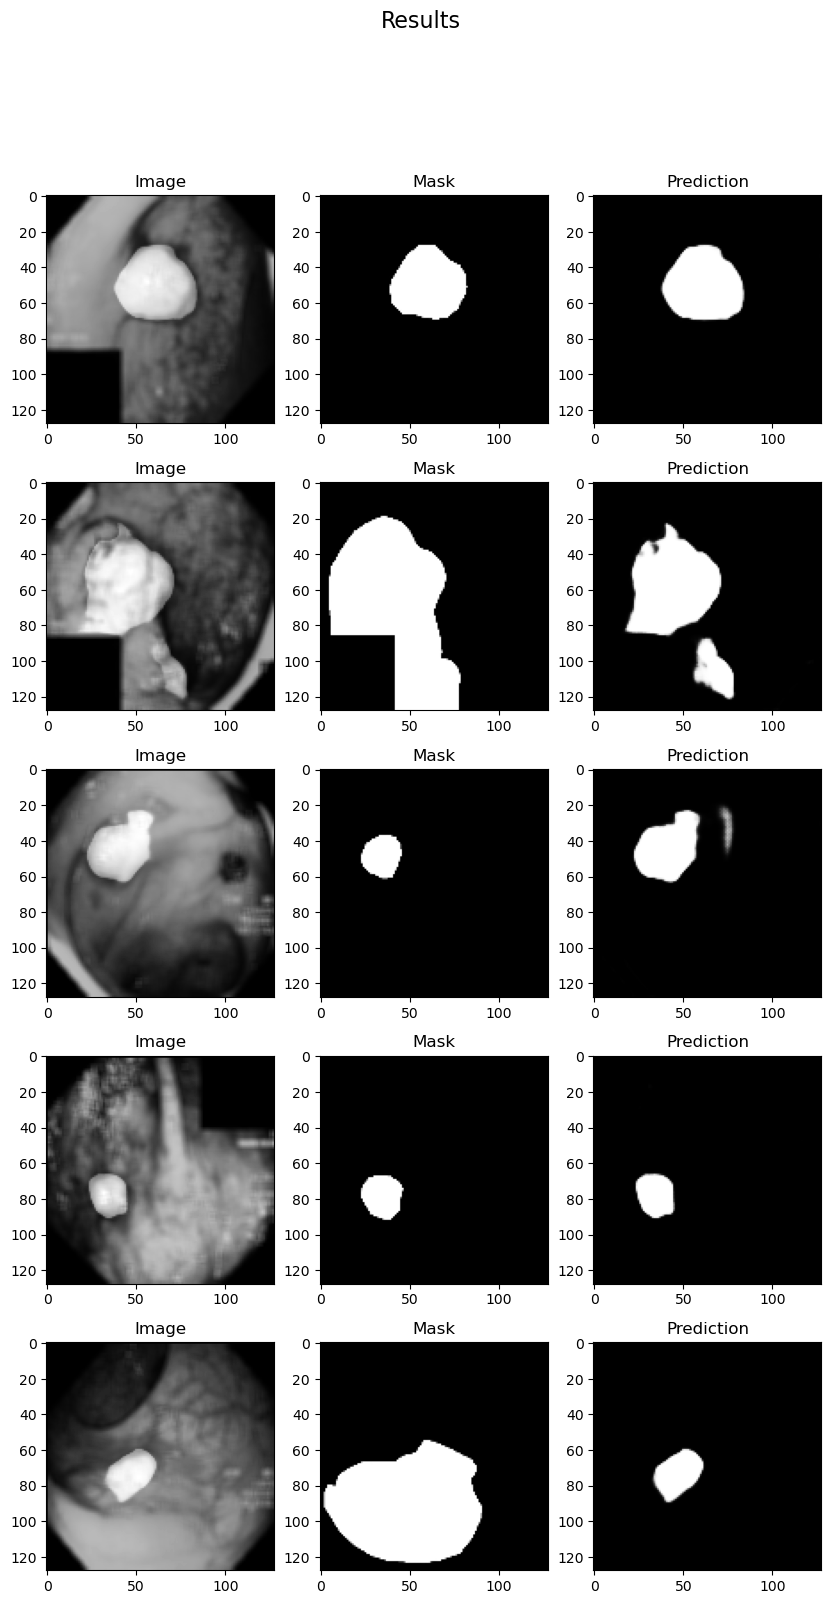

In [93]:
#Visulazing model's results
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, new_X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(new_X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model2.predict(np.expand_dims(new_X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

In [91]:
#Measuring our model
print(f'\033[93m')
y_pred=model2.predict(new_X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score\Dice Coofficient = %.3f' % f1_score)


Mean IoU = 0.740832
Precision Score = 0.650
Recall Score = 0.825
F1 Score\Dice Coofficient = 0.727


In [92]:
#Saving the model for further use
model2.save('/kaggle/working/Learned-Unet2.h5')

7/7 [==============================] - 0s 53ms/step


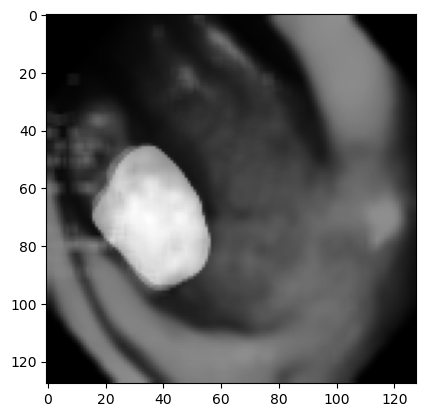

In [98]:
#Merging inputs with their predicted polyp
last_X_train = []
predicts = model.predict(new_X_train)
for i in range(len(new_X_train)):
    pred = (predicts[i] + 4 * new_X_train[i]) / 5
    last_X_train.append(pred)

last_X_train = np.array(last_X_train)
    
last_X_test = []
predicts = model.predict(new_X_test)
for i in range(len(X_test)):
    pred = (predicts[i] + 4 * new_X_test[i]) / 5
    last_X_test.append(pred)

last_X_test = np.array(last_X_test)


plt.imshow(last_X_train[0],  cmap='gray')
plt.show()

In [99]:
model3 = build_model(input_shape=(size, size, 1))
model3.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

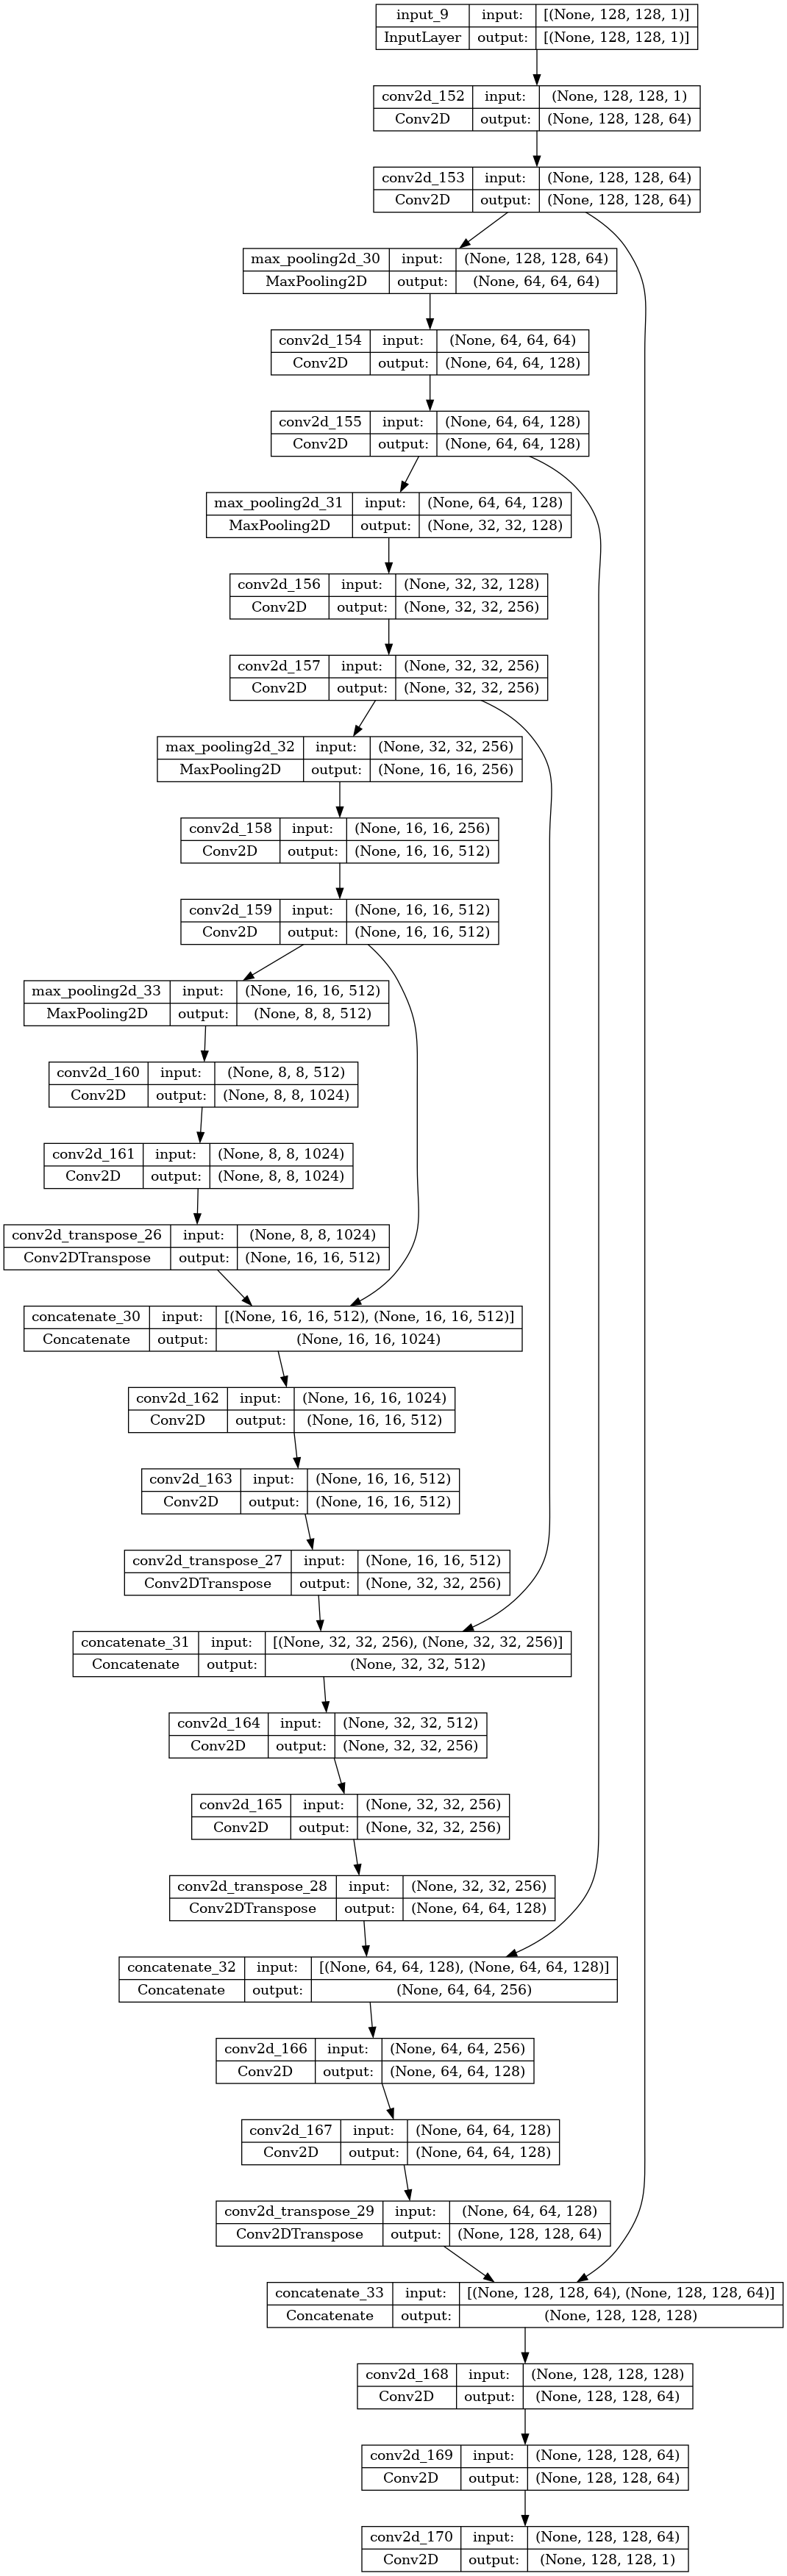

In [100]:
#ploting models structure
tf.keras.utils.plot_model(model3, show_shapes=True)

In [102]:
#printing model's layers
model3.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 128, 128, 64  640         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_153 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_152[0][0]']             
                                )                                                             

In [109]:
#training the model
history = model3.fit(last_X_train, y_train, epochs = 15, validation_data = (last_X_test,y_test))

Epoch 1/15
48/48 [==============================] - 9s 188ms/step - loss: 0.0760 - accuracy: 0.9740 - val_loss: 0.4399 - val_accuracy: 0.9108
Epoch 2/15
48/48 [==============================] - 9s 186ms/step - loss: 0.0501 - accuracy: 0.9745 - val_loss: 0.3915 - val_accuracy: 0.9117
Epoch 3/15
48/48 [==============================] - 9s 187ms/step - loss: 0.0433 - accuracy: 0.9770 - val_loss: 0.4209 - val_accuracy: 0.9121
Epoch 4/15
48/48 [==============================] - 9s 186ms/step - loss: 0.0404 - accuracy: 0.9779 - val_loss: 0.4249 - val_accuracy: 0.9121
Epoch 5/15
48/48 [==============================] - 9s 186ms/step - loss: 0.0390 - accuracy: 0.9783 - val_loss: 0.4254 - val_accuracy: 0.9122
Epoch 6/15
48/48 [==============================] - 9s 187ms/step - loss: 0.0373 - accuracy: 0.9788 - val_loss: 0.4342 - val_accuracy: 0.9123
Epoch 7/15
48/48 [==============================] - 9s 186ms/step - loss: 0.0359 - accuracy: 0.9793 - val_loss: 0.4408 - val_accuracy: 0.9123
Epoch 

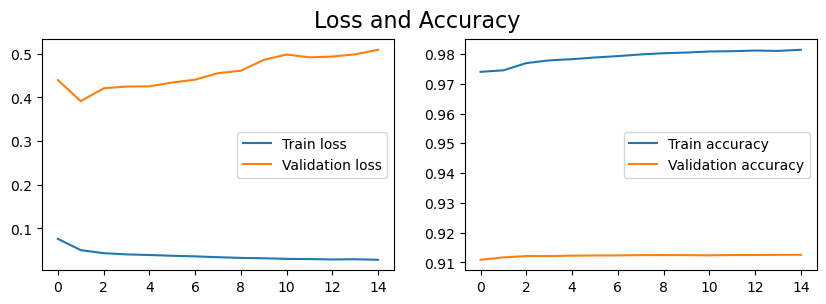

In [110]:
#Ploting loss and acuracy growth based on epochs
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

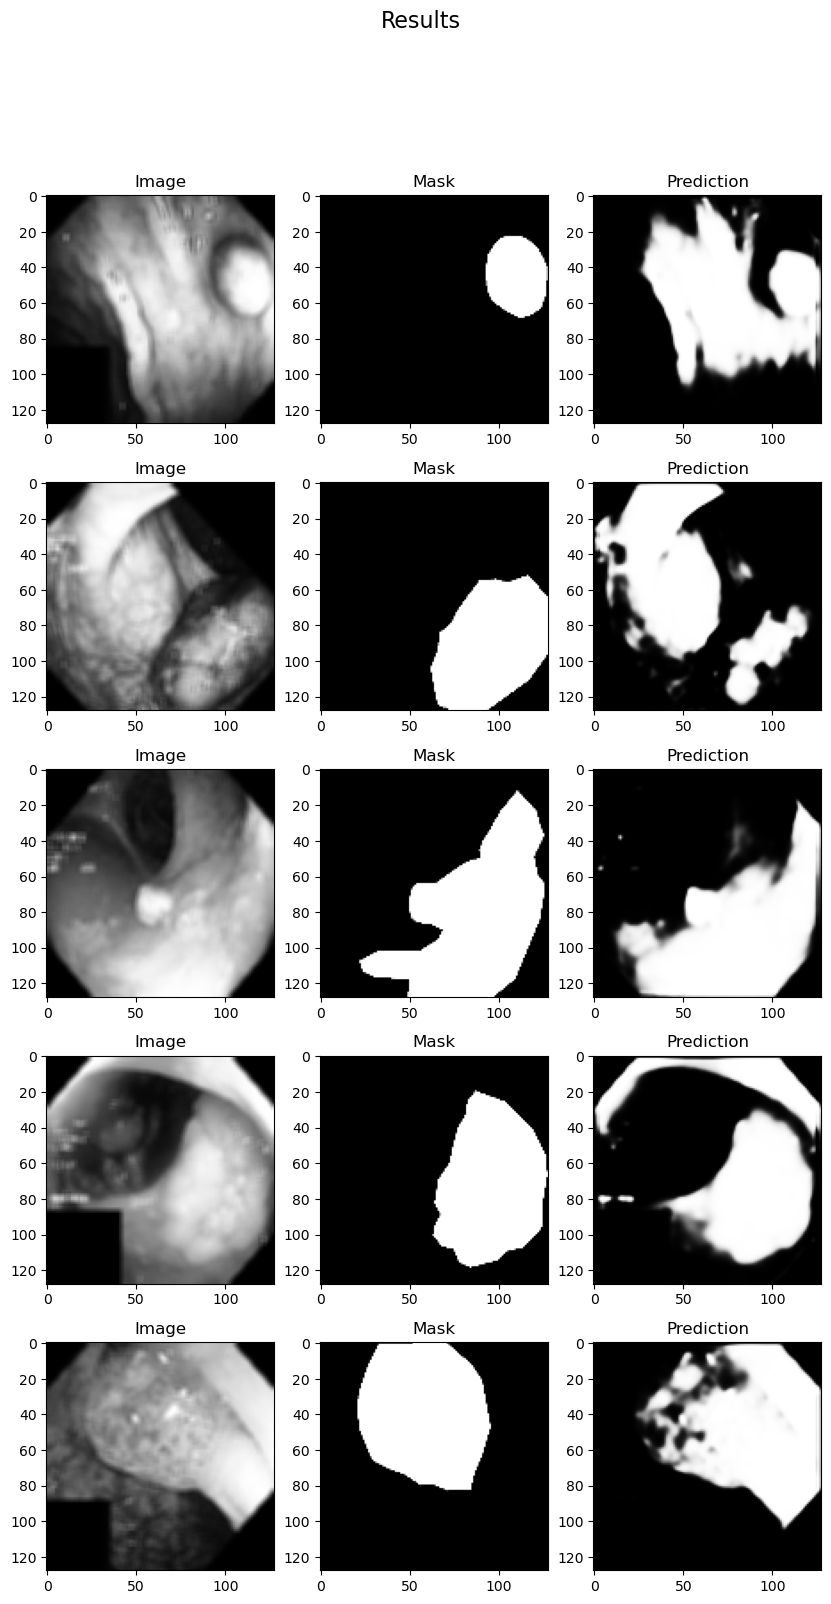

In [117]:
#Visulazing model's results
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model3.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

In [118]:
#Measuring our model
print(f'\033[93m')
y_pred=model3.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score\Dice Coofficient = %.3f' % f1_score)


Mean IoU = 0.4598146
Precision Score = 0.682
Recall Score = 0.301
F1 Score\Dice Coofficient = 0.418
